## 공용 코드 

In [1]:
# 파이썬
# ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 공통 모듈 임포트
import numpy as np
import pandas as pd
import os

path = "c:/Windows/Fonts/malgun.ttf"

from matplotlib import font_manager, rc

import platform

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
    
# Jupyter Notebook의 출력을 소수점 이하 3자리로 제한
%precision 3

import sklearn
assert sklearn.__version__ >= "0.20"

# 시드 고정
np.random.seed(21)

## 데이터 가져오기

In [2]:
origin_data = pd.read_excel('./3차_VOD_2308.xlsx')
weather_data = pd.read_excel('8_10월_날씨.xlsx')

In [ ]:
origin_data.head()

In [4]:
weather_data.head()
print(type(weather_data['date'][0])) # timestamp 타입

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


### 데이터 전처리

In [5]:
# 불필요한 컬럼 삭제
drop_data = origin_data.drop(['Unnamed: 0', 'subsr', 'use_tms', 'SMRY', 'ACTR_DISP', 'disp_rtm'], axis = 1, inplace = False)
#origin_data['Unnamed: 0']

In [15]:
# 연/월/일 데이터 구분
day_data = []

for _, item in drop_data.iterrows():
    day_data.append(str(item['strt_dt'])[:8])

In [16]:
# 연/월/일 데이터 컬럼으로 추가
drop_data['day'] = day_data

In [ ]:
# 데이터 컬럼 수정

# 저장할 리스트 생성
new_day = []

# 수정할 데이터 생성
for _, item in drop_data.iterrows():
    day = str(item['day'])
    new_day.append(str(day[:4] + '-' + day[4:6] + '-' + day[6:]))
    
# 데이터 수정
drop_data['day'] = new_day

# 확인
print(drop_data.head())
print(type(drop_data['day'][0])) # str 타입

### 날씨 데이터 추가

In [9]:
# 날씨 데이터의 타입 변경하기 - 기존 데이터와 일치를 확인하기 위해서

# 데이터 타입 확인
#weather_data.dtypes

# 데이터 타입 변경 
weather = weather_data.astype({'date' : 'str'})

In [10]:
weather_list = {}

for _, item in weather.iterrows():
    weather_list[item['date']] = item['weather']
    
# 확인
print(weather_list)

{'2023-08-01': '맑음', '2023-08-02': '맑음', '2023-08-03': '맑음', '2023-08-04': '맑음', '2023-08-05': '맑음', '2023-08-06': '비', '2023-08-07': '맑음', '2023-08-08': '맑음', '2023-08-09': '비', '2023-08-10': '비', '2023-08-11': '비', '2023-08-12': '비', '2023-08-13': '흐림', '2023-08-14': '흐림', '2023-08-15': '흐림', '2023-08-16': '비', '2023-08-17': '맑음', '2023-08-18': '비', '2023-08-19': '맑음', '2023-08-20': '비', '2023-08-21': '비', '2023-08-22': '비', '2023-08-23': '비', '2023-08-24': '비', '2023-08-25': '비', '2023-08-26': '흐림', '2023-08-27': '비', '2023-08-28': '비', '2023-08-29': '비', '2023-08-30': '비', '2023-08-31': '흐림', '2023-09-01': '맑음', '2023-09-02': '맑음', '2023-09-03': '비', '2023-09-04': '비', '2023-09-05': '비', '2023-09-06': '맑음', '2023-09-07': '맑음', '2023-09-08': '맑음', '2023-09-09': '맑음', '2023-09-10': '흐림', '2023-09-11': '흐림', '2023-09-12': '흐림', '2023-09-13': '비', '2023-09-14': '흐림', '2023-09-15': '비', '2023-09-16': '비', '2023-09-17': '비', '2023-09-18': '흐림', '2023-09-19': '흐림', '2023-09-20': '비', '202

In [19]:
# 데이터 컬럼에 추가
add_weather_list = []

for _, item in drop_data.iterrows():
    add_weather_list.append(weather_list[item['day']])

# 확인
#print(add_weather_list)

# 데이터 컬럼에 추가
drop_data['weather'] = add_weather_list


In [ ]:
drop_data.head()

In [ ]:
# 세부 장르 컬럼은 겹치는 장르가 다른데도 이름이 겹치는 경우가 있으므로
# 둘을 묶어서 하나의 장르 컬럼을 생성
drop_data['genre'] = drop_data['ct_cl'] + '&' + drop_data['genre_of_ct_cl']
# 확인
print(drop_data.head())

In [24]:
# 불필요한 컬럼 제거
weather_data = drop_data.drop(['asset_nm', 'ct_cl', 'genre_of_ct_cl', 'strt_dt'], axis = 1)

In [25]:
# 확인
print(weather_data.head(3))

          day weather        genre
0  2023-08-12       비  TV 시사/교양&기타
1  2023-08-16       비  TV 시사/교양&기타
2  2023-08-29       비  TV 시사/교양&기타


In [26]:
# 메모리 정리
import gc
gc.collect() 

466

### 단순 선형 회귀

In [27]:
# 평가 지표를 위한 함수
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# RMSLE 를 구하는 함수
def rmsle(y, pred):
    # 로그를 적용
    # log 함수를 사용하면 NaN 에서 문제가 발생하기 때문에
    # log1p 함수를 대신 사용함
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    
    return rmsle

# RMSE 를 구하는 함수
def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

# 평가 지표를 구하는 함수
def evaluate_regr(y, pred):
    rmsle_val = rmsle(y, pred)
    rmse_val = rmse(y, pred)
    mae_val = mean_absolute_error(y, pred)
    print('RMSLE : {0}, RMSE : {1}, MAE : {2}'.format(rmsle_val, rmse_val, mae_val))

In [63]:
# 단순 선형 회귀 적용
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# 데이터 생성
y_target = weather_data['genre']
X_features = weather_data['weather']
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target,
                                                   test_size = 0.2, random_state = 21)

In [72]:
# 원 핫 인코딩 수행
X_features_one = pd.get_dummies(X_features, columns = ['weather'])
y_target_log = pd.get_dummies(y_target, columns = ['genre'])

# 수행 확인
#print(X_features_one.head())
#print(y_target_log.head())

In [65]:
# 원 핫 인코딩을 수행했으므로 다시 데이터를 분할
X_train, X_test, y_train, y_test = train_test_split(X_features_one, y_target_log,
                                                   test_size = 0.2, random_state = 21)

In [ ]:
# 단순 선형 회귀 수행 
# 데이터의 타입이 float 이 아니라 str 이라면 수행 불가능
# 원 핫 인코딩을 통해 정확도를 높이면서 타입을 변환
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

#print(pred)
evaluate_regr(y_test, pred)

### 세부 장르별 날씨

In [104]:
print(X_features_one.info())
print(y_target_log.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5615 entries, 0 to 5614
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   day         5615 non-null   object
 1   genre       5615 non-null   object
 2   weather_맑음  5615 non-null   uint8 
 3   weather_비   5615 non-null   uint8 
 4   weather_흐림  5615 non-null   uint8 
dtypes: object(2), uint8(3)
memory usage: 104.3+ KB
None
<class 'pandas.core.series.Series'>
RangeIndex: 5615 entries, 0 to 5614
Series name: TV 시사/교양&기타
Non-Null Count  Dtype
--------------  -----
5615 non-null   uint8
dtypes: uint8(1)
memory usage: 5.6 KB
None


In [146]:
# 세부 장르에 대해 선형회귀

# 선형 회귀에 사용할 데이터
y_target = weather_data['genre']
X_features = weather_data['weather']

# 원 핫 인코딩 수행
X_features_one = pd.get_dummies(X_features, columns = ['weather'])
y_target_log = (pd.get_dummies(weather_data, columns = ['genre']))['genre_TV드라마&기타']

# 원 핫 인코딩을 수행한 데이터를 분할
X_train, X_test, y_train, y_test = train_test_split(X_features_one, y_target_log,
                                                   test_size = 0.2, random_state = 21)

# 단순 선형 회귀 수행 후 결과 확인 
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

print(pred)
evaluate_regr(y_test, pred)

[0.231 0.231 0.153 ... 0.168 0.231 0.231]
RMSLE : 0.28021371514498744, RMSE : 0.39974836819009535, MAE : 0.3192525500435581


In [139]:
pd.get_dummies(weather_data, columns = ['genre'])

,day,weather,genre_TV 시사/교양&기타,genre_TV 시사/교양&인물/다큐,genre_TV 연예/오락&기타,genre_TV드라마&기타,genre_TV드라마&외화 시리즈,genre_TV애니메이션&기타,genre_TV애니메이션&명랑/코믹,genre_TV애니메이션&액션/모험,...,genre_영화&무협,genre_영화&애니메이션,genre_영화&액션/어드벤쳐,genre_영화&역사,genre_영화&코미디,genre_우리동네&연예/오락,genre_키즈&기타,genre_키즈&애니메이션,genre_키즈&오락,genre_키즈&학습
0,2023-08-12,비,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2023-08-16,비,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2023-08-29,비,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2023-08-13,흐림,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2023-08-04,맑음,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5610,2023-08-10,비,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5611,2023-08-10,비,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5612,2023-08-10,비,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5613,2023-08-10,비,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [149]:
# 계수 확인
print(lr_reg.coef_)

array([-0.016,  0.047, -0.031])

In [116]:
X_features_one

,맑음,비,흐림
0,0,1,0
1,0,1,0
2,0,1,0
3,0,0,1
4,1,0,0
...,...,...,...
5610,0,1,0
5611,0,1,0
5612,0,1,0
5613,0,1,0


<Axes: >

C:\Users\USER\anaconda3\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
C:\Users\USER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


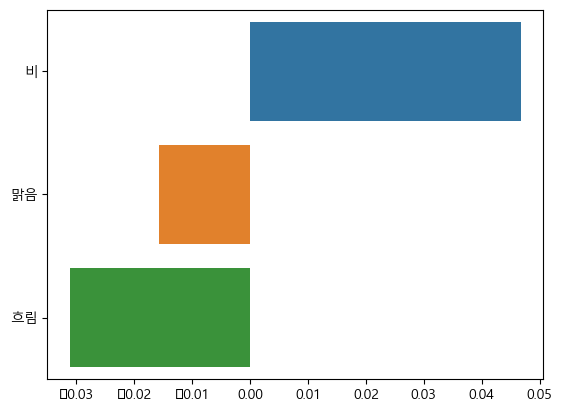

In [117]:
# 선형 회귀에서 feature 의 회귀 계수를 확인
coef = pd.Series(lr_reg.coef_, index = X_features_one.columns)
coef_sort = coef.sort_values(ascending = False)

import seaborn as sns
sns.barplot(x = coef_sort.values, y = coef_sort.index)

In [120]:
# 선형 회귀가 아닌 여러 모델 적용
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

# 모델과 데이터를 받아서 훈련하고 평가 지표를 출력하는 함수 생성
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1 = False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1:
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print(model.__class__.__name__)
    evaluate_regr(y_test, pred)
    
rf_reg = RandomForestRegressor(n_estimators = 500)
gbm_reg = GradientBoostingRegressor(n_estimators = 500)
xgb_reg = XGBRegressor(n_estimators = 500)

for model in [rf_reg, gbm_reg, xgb_reg]:
    get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1 = True)

RandomForestRegressor
RMSLE : 0.3997527262791798, RMSE : 0.6991883495037478, MAE : 0.4778248405264602
GradientBoostingRegressor
RMSLE : 0.39974836819009535, RMSE : 0.6991963153539449, MAE : 0.47775508188660515
XGBRegressor
RMSLE : 0.3997488021850586, RMSE : 0.6991973519325256, MAE : 0.477756142616272


### 세부 장르별 회귀 계수 비교하기

In [121]:
# 파일에서 세부 장르 데이터 가져오기

open_file = open('./text files/detail_genre.txt', 'r', encoding = 'utf8')
text = open_file.read()
open_file.close()

data_list = text.split('\n')
data_list = data_list[:-2]

In [ ]:
new_data_list = []
for item in data_list:
    item = item.replace('&', '/')
    new_data_list.append(item.replace('-', '&'))
    
print(new_data_list)


In [ ]:
# 세부 장르별 선형 회귀 수행
X_features = weather_data['weather']
X_features_one = pd.get_dummies(X_features, columns = ['weather'])
lr_list = []

for detail_genre in new_data_list:

    # 원 핫 인코딩 수행
    oh_genre = 'genre_' + detail_genre
    y_target_log = (pd.get_dummies(weather_data, columns = ['genre']))[oh_genre]

    # 원 핫 인코딩을 수행한 데이터를 분할
    X_train, X_test, y_train, y_test = train_test_split(X_features_one, y_target_log,
                                                       test_size = 0.2, random_state = 21)

    # 단순 선형 회귀 수행 후 결과 확인 
    lr_reg = LinearRegression()
    lr_reg.fit(X_train, y_train)
    pred = lr_reg.predict(X_test)
    
    # 선형 회귀의 회귀 계수 출력
    print(detail_genre, ' : ', lr_reg.coef_)
    # 회귀 계수 저장
    lr_list.append([detail_genre, lr_reg.coef_])

In [ ]:
# 확인
lr_list[:3]

In [ ]:
# 결과 비교
max_s = -1
max_r = -1
max_c = -1

sunny, rainy, cloudy = None, None, None

# 데이터는 비, 맑음, 흐림 순서
for lr in lr_list:
    if lr[1][0] > max_r:
        max_r = lr[1][0]
        rainy = lr[0]
        
    if lr[1][1] > max_s:
        max_s = lr[1][1]
        sunny = lr[0]
        
    if lr[1][2] > max_c:
        max_c = lr[1][2]
        cloudy = lr[0]
        
print('Rain : ', rainy, max_r)
print('Sun : ', sunny, max_s)
print('Cloud : ', cloudy, max_c)

In [168]:
# 날씨별로 상위 3개 장르 추출

# 날씨별 정렬
sorted_data_rainy = sorted(lr_list, key=lambda x: x[1][0])[:3]
sorted_data_sunny = sorted(lr_list, key=lambda x: x[1][1])[:3]
sorted_data_cloudy = sorted(lr_list, key=lambda x: x[1][2])[:3]

print('비 -> ')
for item in sorted_data_rainy:
    print(item[0])
print('맑음 -> ')
for item in sorted_data_sunny:
    print(item[0])
print('구름 -> ')
for item in sorted_data_cloudy:
    print(item[0])

비 -> 
TV 연예/오락&기타
TV드라마&기타
영화&액션/어드벤쳐
맑음 -> 
키즈&기타
영화&액션/어드벤쳐
TV 시사/교양&기타
구름 -> 
TV드라마&기타
키즈&기타
키즈&애니메이션
